# test01
## More testing, but with brownian motion

In [11]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_curve, auc
from prophet_rmse import stock_rmse
import seaborn as sns
from datetime import datetime, timezone

[*********************100%***********************]  1 of 1 completed


array([[0.01903108, 0.01905919, 0.01891265, ..., 0.01898499, 0.01881476,
        0.01898939],
       [0.01898713, 0.01912402, 0.01891932, ..., 0.01900896, 0.01889477,
        0.01911067],
       [0.01915942, 0.01909353, 0.01897049, ..., 0.01885877, 0.01897967,
        0.01912901],
       ...,
       [0.01802272, 0.01933618, 0.01479766, ..., 0.01618827, 0.02020559,
        0.01829942],
       [0.01809061, 0.0192915 , 0.0148359 , ..., 0.01606604, 0.02015897,
        0.01824567],
       [0.01802273, 0.01924136, 0.01473778, ..., 0.01604364, 0.02018585,
        0.01839986]])

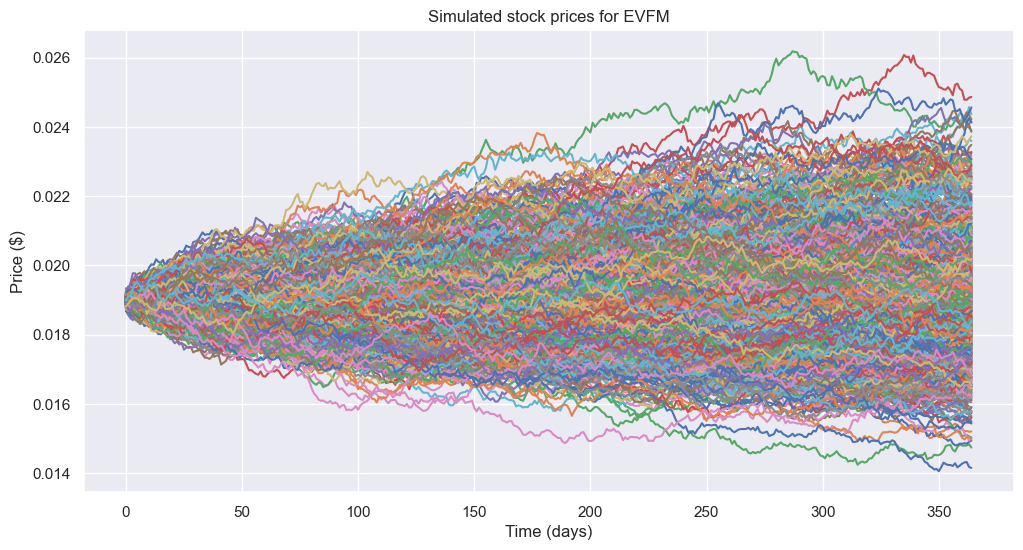

In [12]:
# Load stock data for a particular ticker
ticker = "EVFM"
raw_data = yf.download(ticker, start="2010-01-01", end="2023-04-10", interval='1d')

# Compute daily returns and volatility
log_returns = np.log(1 + raw_data['Adj Close'].pct_change())
volatility = log_returns.std()

# Define parameters for Brownian motion
S0 = raw_data['Adj Close'][-1] # current stock price
T = 365 # number of days to simulate
N = 1000 # number of simulations
dt = 1/365 # time step
mu = log_returns.mean() # expected return

# Simulate Brownian motion
W = np.random.standard_normal(size=(T,N))
W = np.cumsum(W,axis=0)
X = (mu - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * W
S = S0 * np.exp(X)

# Plot simulated stock prices
plt.figure(figsize=(12,6))
plt.plot(S)
plt.title(f'Simulated stock prices for {ticker}')
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')
plt.savefig('out.png')
S

In [13]:
# Prepare data for Prophet model
df = pd.DataFrame({'ds': raw_data.index, 'y': raw_data['Adj Close']})
df.reset_index(inplace=True, drop=True)
print('done')

done


**building, compiling, and training the model**

18:33:31 - cmdstanpy - INFO - Chain [1] start processing
18:33:33 - cmdstanpy - INFO - Chain [1] done processing


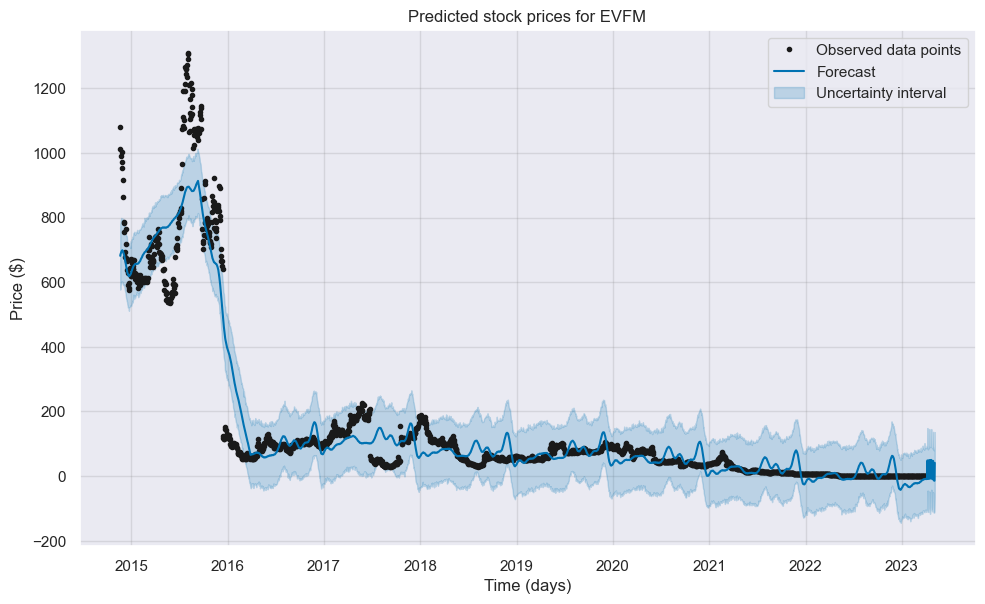

In [14]:
# Create and fit the Prophet model
m = Prophet(daily_seasonality=True)

m.fit(df)

# Generate predictions for the next 30 days
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# Plot the predicted prices
fig = m.plot(forecast)
plt.title(f'Predicted stock prices for {ticker}')
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

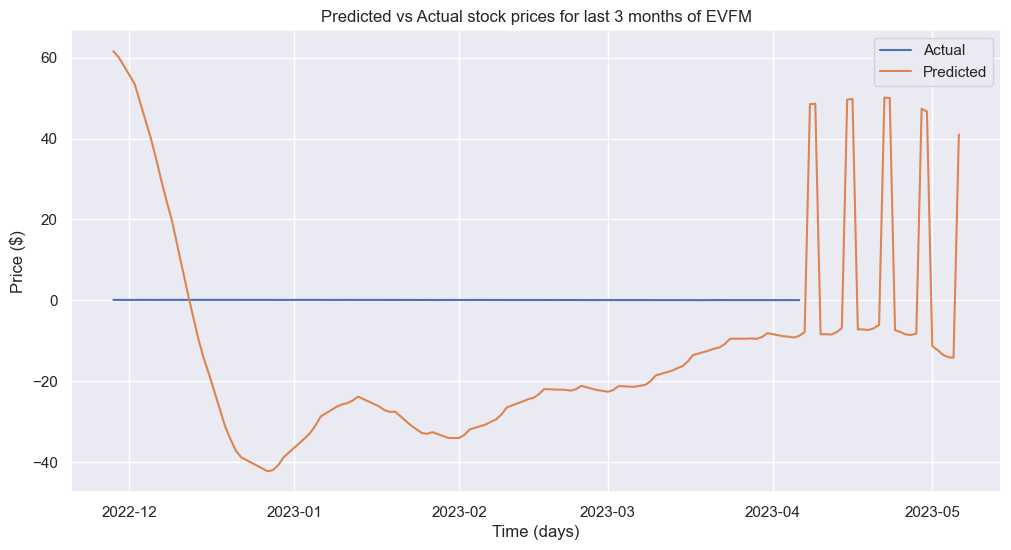

In [15]:
# Plot the predicted vs actual prices for range
last_month = forecast.iloc[-120:]
last_month_actual = raw_data.iloc[-90:]
fig2 = plt.figure(figsize=(12,6))
plt.plot(last_month_actual.index, last_month_actual['Adj Close'], label='Actual')
plt.plot(last_month.ds, last_month.yhat, label='Predicted')
plt.title(f'Predicted vs Actual stock prices for last 3 months of {ticker}')
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')
plt.autoscale()
plt.legend()
plt.savefig('out1.png')
plt.show()

**model evaluation**

In [16]:
# Compute evaluation metrics
actual = raw_data['Adj Close'][-90:]
predicted = forecast['yhat'][-120:-30]
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 25.65
MSE: 809.21
RMSE: 28.45


In [17]:
# Print the predicted stock prices for the next 30 days
print("Predicted and actual stock prices for the next 30 days:")
print(forecast[['ds', 'yhat']][-60:-30], raw_data['Adj Close'][-30:])

Predicted and actual stock prices for the next 30 days:
             ds       yhat
2078 2023-02-24 -21.190471
2079 2023-02-27 -22.256960
2080 2023-02-28 -22.421933
2081 2023-03-01 -22.658105
2082 2023-03-02 -22.238150
2083 2023-03-03 -21.264914
2084 2023-03-06 -21.432554
2085 2023-03-07 -21.180921
2086 2023-03-08 -20.964548
2087 2023-03-09 -20.071138
2088 2023-03-10 -18.618887
2089 2023-03-13 -17.464250
2090 2023-03-14 -16.854559
2091 2023-03-15 -16.339866
2092 2023-03-16 -15.215943
2093 2023-03-17 -13.606767
2094 2023-03-20 -12.444300
2095 2023-03-21 -11.981380
2096 2023-03-22 -11.680030
2097 2023-03-23 -10.828184
2098 2023-03-24  -9.540399
2099 2023-03-27  -9.527512
2100 2023-03-28  -9.470071
2101 2023-03-29  -9.565641
2102 2023-03-30  -9.091194
2103 2023-03-31  -8.151399
2104 2023-04-03  -8.929447
2105 2023-04-04  -9.034756
2106 2023-04-05  -9.239325
2107 2023-04-06  -8.821236 Date
2023-02-24    0.035
2023-02-27    0.031
2023-02-28    0.028
2023-03-01    0.028
2023-03-02    0.028
20

In [18]:
forecast[['ds', 'yhat']][-30:]

,ds,yhat
2108,2023-04-07,-7.888266
2109,2023-04-08,48.508376
2110,2023-04-09,48.614606
2111,2023-04-10,-8.447688
2112,2023-04-11,-8.427233
2113,2023-04-12,-8.495741
2114,2023-04-13,-7.941942
2115,2023-04-14,-6.884406
2116,2023-04-15,49.615079
2117,2023-04-16,49.792417


,ds,yhat
2093,2023-03-17,-13.606767
2094,2023-03-20,-12.444300
2095,2023-03-21,-11.981380
2096,2023-03-22,-11.680030
2097,2023-03-23,-10.828184
2098,2023-03-24,-9.540399
2099,2023-03-27,-9.527512
2100,2023-03-28,-9.470071
2101,2023-03-29,-9.565641
2102,2023-03-30,-9.091194


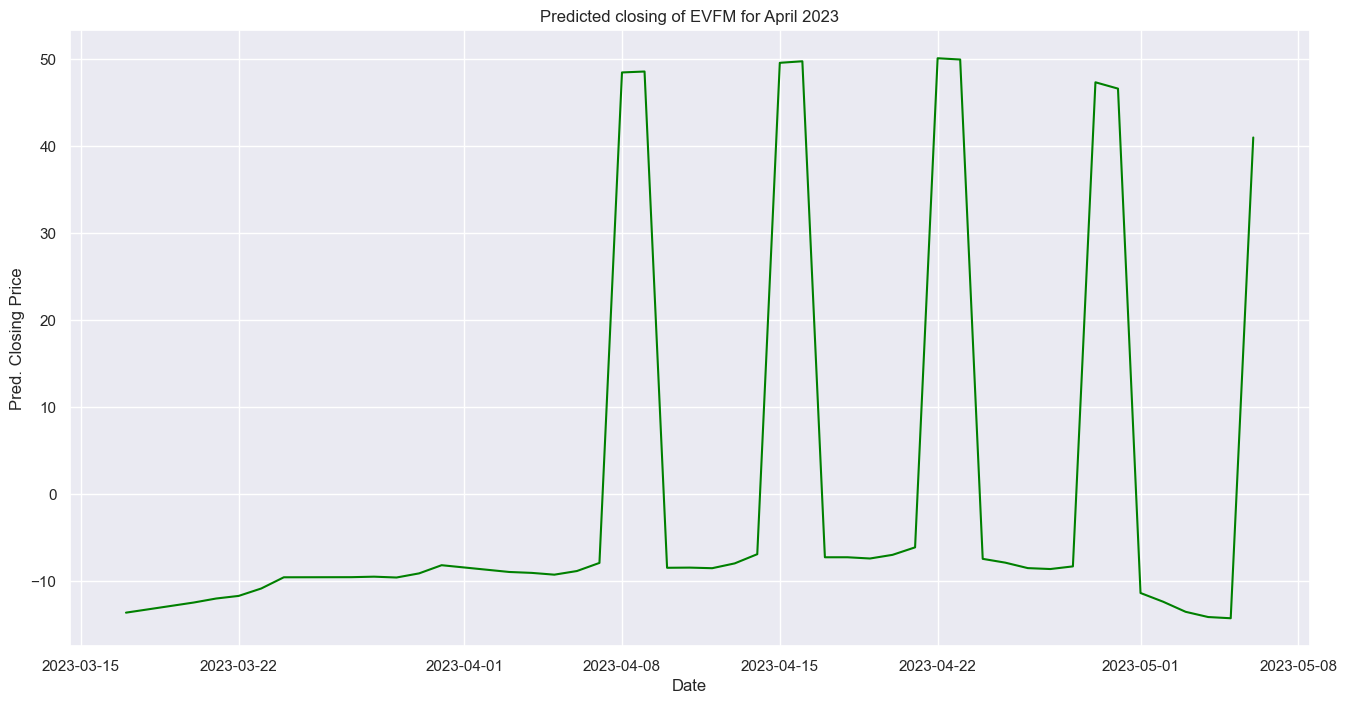

In [19]:
sns.lineplot(forecast[['ds', 'yhat']][-45:], x='ds', y='yhat', c='green')
sns.set(rc={"figure.figsize":(16, 8)}) #width=8, height=4
plt.xlabel('Date')
plt.ylabel('Pred. Closing Price')
plt.title(f'Predicted closing of {ticker} for April 2023')
forecast[['ds', 'yhat']][-45:]

In [20]:
stock_rmse('AAPL')

[*********************100%***********************]  1 of 1 completed


18:33:37 - cmdstanpy - INFO - Chain [1] start processing
18:33:39 - cmdstanpy - INFO - Chain [1] done processing


{'ticker': 'AAPL',
 'yhat': 0         6.091886
 1         6.013249
 2         5.999495
 3         5.886788
 4         5.795694
            ...    
 3329    168.648573
 3330    168.733451
 3331    168.731606
 3332    168.762065
 3333    169.056056
 Name: yhat, Length: 3334, dtype: float64,
 'yhat_lower': 0        -3.420994
 1        -3.312533
 2        -3.558406
 3        -4.521551
 4        -3.852799
            ...    
 3329    158.764669
 3330    159.015494
 3331    158.900391
 3332    158.522974
 3333    158.000768
 Name: yhat_lower, Length: 3334, dtype: float64,
 'yhat_upper': 0        16.300334
 1        16.164546
 2        16.037462
 3        16.025720
 4        15.992704
            ...    
 3329    178.032475
 3330    178.820067
 3331    178.822709
 3332    178.639928
 3333    178.737856
 Name: yhat_upper, Length: 3334, dtype: float64,
 'trend': 0         6.346286
 1         6.357497
 2         6.368708
 3         6.379919
 4         6.391130
            ...    
 3329    169.91